<a href="https://colab.research.google.com/github/isaacd68/MAT494-data-science/blob/main/4_1Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laplacian Matrix**

The Laplacian matrix of a graph is sometimes referred to as the “Kirchoff matrix” or the “admittance matrix”, and is useful in many parts of spectral graph theory. In particular, the eigen-decomposition of the laplacian matrix can give insight into many properties of the graph.

In [ ]:
def get_laplacian(self, sims, ids, alpha=0.99):
        """Get Laplacian_alpha matrix
        """
        affinity = self.get_affinity(sims, ids)
        num = affinity.shape[0]
        degrees = affinity @ np.ones(num) + 1e-12
        # mat: degree matrix ^ (-1/2)
        mat = sparse.dia_matrix(
            (degrees ** (-0.5), [0]), shape=(num, num), dtype=np.float32)
        stochastic = mat @ affinity @ mat
        sparse_eye = sparse.dia_matrix(
            (np.ones(num), [0]), shape=(num, num), dtype=np.float32)
        lap_alpha = sparse_eye - alpha * stochastic
        return lap_alpha


In [ ]:
def get_laplacian(self, sims, ids, alpha=0.99):
        """Get Laplacian_alpha matrix
        """
        logger.info('get_affinity')
        affinity = self.get_affinity(sims, ids)
        logger.info('get_affinity ... done')
        num = affinity.shape[0]
        degrees = affinity @ np.ones(num) + 1e-12
        # mat: degree matrix ^ (-1/2)
        mat = sparse.dia_matrix(
            (degrees ** (-0.5), [0]), shape=(num, num), dtype=np.float32)
        logger.info('calc stochastic = mat @ affinity @ mat')
        stochastic = mat @ affinity @ mat
        sparse_eye = sparse.dia_matrix(
            (np.ones(num), [0]), shape=(num, num), dtype=np.float32)
        lap_alpha = sparse_eye - alpha * stochastic
        return lap_alpha

In [ ]:
def get_laplacian(self, adj_matrix, normalize=True):
        """Compute pairwise distance of a point cloud.

        Args:
            pairwise distance: tensor (batch_size, num_points, num_points)

        Returns:
            pairwise distance: (batch_size, num_points, num_points)
        """
        if normalize:
            D = tf.reduce_sum(adj_matrix, axis=1)  # (batch_size,num_points)
            eye = tf.ones_like(D)
            eye = tf.matrix_diag(eye)
            D = 1 / tf.sqrt(D)
            D = tf.matrix_diag(D)
            L = eye - tf.matmul(tf.matmul(D, adj_matrix), D)
        else:
            D = tf.reduce_sum(adj_matrix, axis=1)  # (batch_size,num_points)
            # eye = tf.ones_like(D)
            # eye = tf.matrix_diag(eye)
            # D = 1 / tf.sqrt(D)
            D = tf.matrix_diag(D)
            L = D - adj_matrix
        return L 

# Graph Laplacian

We will begin with a toy make_moons data set from python library scikit-learn.

In [ ]:
import numpy as np
from scipy import sparse
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score
import networkx as nx
import matplotlib.pyplot as plt
random_state = 213
np.random.seed(random_state)
data_size = 150
features,y = make_moons(n_samples=data_size, noise=0.07, random_state=213)

K-nearest neighbors graph can be constructed in 2 modes — ‘distance’ or ‘connectivity’.
With ‘distance’ mode, the edges represent the distance between 2 nodes and with ‘connectivity’ , the graph has edge weight 1 or 0 to denote presence or absence of an edge between them. We will choose euclidean distance metric to compute the distance.

In [ ]:
n_neighbors = 10
knn_dist_graph = kneighbors_graph(X=features,
                                 n_neighbors=n_neighbors,
                                 mode='distance',
                                 metric='euclidean',
                                 n_jobs=6)

It returns a sparse graph with edges representing the distance between the data points. The distance of the first data points with its 50 neighbors is shown below. Note the sparsity of the graph and it will have continuous value representing distance at only those places/indices in the matrix which corresponds to its k nearest neighbors, the rest will be zero.

In [ ]:
knn_dist_graph.todense()[0][:,:50]

matrix([[0.        , 0.        , 0.07266041, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.1943875 , 0.        ,
         0.        , 0.        , 0.15397041, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.06969749, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

This data is commonly used to find groups within the data points where similar data points lie in the same class or cluster.
Similarly in other such cases when you want to capture similarity within the data points rather than the distance, we can convert this graph to similarity based using a Gaussian kernel with its width (sigma = 1 ) and the distance d(x1, x2) is the euclidean distance in the non zero places in the sparse graph above. Note that the locations with distance = 0 in the array above mean that the distance is beyond the largest distance of k nearest neighbors. This value can be interpreted as highest similarity when fed to Gaussian kernel. So, we will only apply this kernel to indices containing distances.

In [ ]:
sigma = 1
similarity_graph = sparse.csr_matrix(knn_dist_graph.shape)
nonzeroindices = knn_dist_graph.nonzero()
similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
similarity_graph.todense()[0][:,:50]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


matrix([[0.        , 0.        , 0.99736371, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.98128411, 0.        ,
         0.        , 0.        , 0.98821653, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.99757408, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

By extension of all the above properties, and the fact that the eigen vector separates data points in groups, it is used for clustering. This method is called Spectral clustering.
This is performed by choosing a threshold to separate data points into 2 clusters from the 1st smallest eigen vector. For more than 2 clusters, we can use Kmeans algorithm to obtain K clusters directly from the first smallest K eigen vectors.

Graph partitioning — In this, the vertices are partitioned into disjoints sets. The graph is partitioned such that the edges within the groups have high weights (points within clusters are similar) and the edges between groups have small weights (points in different clusters are dissimilar to each other).

In [ ]:
degree_matrix = similarity_graph.sum(axis=1)
diagonal_matrix = 0
np.diag(np.asarray(degree_matrix).reshape(data_size,))
L =  diagonal_matrix - similarity_graph

In [ ]:
x = np.ones(shape=(data_size,1))
Q = np.dot(np.dot(x.T, L.todense()), x)
Q.round(10)

array([[-1477.30855356]])

In [ ]:
# Finding eigen values and eigen vectors
e, evecs = np.linalg.eig(L.todense())
e.shape, evecs.shape
# No. of eigen values equal to 0
e_rounded_off = e.round(5)
e_rounded_off[e_rounded_off == 0].shape
# No. of connected components
nx.connected_components(nx.graph)

<generator object connected_components at 0x7fe684ff8750>

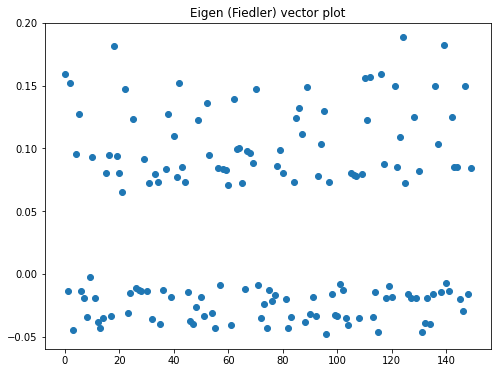

TypeError: ignored

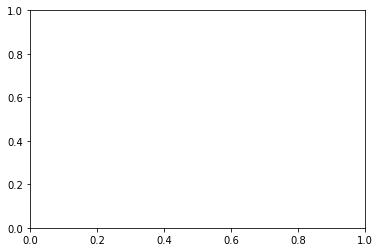

In [83]:
# Get smallest non-zero eigen value's index for obtaining partition to cluster
fiedler_index = sorted_indices

# The eigen vector for smallest non-zero eigen value i.e plotting the Fiedler vector
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), evecs[:,fiedler_index].tolist())
plt.title("Eigen (Fiedler) vector plot")
plt.show()
fiedler_vector = evecs[:,fiedler_index].copy()

# Thresholding the values in this eigen vector at 0
fiedler_vector[fiedler_vector < 0.0] = 0
fiedler_vector[fiedler_vector > 0.0] = 1
new_labels = np.asarray(fiedler_vector)[:,0]
# Plot cluster result
plt.scatter(features[:,0], features[:,1], c=(150))
plt.title("Clusters plot")
plt.show()

In [76]:
# Evaluation of clustering result of the above procedure
homogeneity_score(y, new_labels), completeness_score(y, new_labels), v_measure_score(y, new_labels)

ValueError: ignored

In [ ]:
num_clusters = 2
kmean_labels = KMeans(n_clusters=num_clusters, random_state=random_state, n_jobs=6).fit_predict(features)
plt.scatter(features[:,0], features[:,1],                                                                           c=kmean_labels.astype(float))
plt.show()

In [ ]:
# Evaluation of clustering result of KMeans
homogeneity_score(y, kmean_labels), completeness_score(y, kmean_labels), v_measure_score(y, kmean_labels)
# Scores
# (0.1836464702880451, 0.1837407327840609, 0.18369358944333708)